In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

AttributeError: 'NoneType' object has no attribute 'replace'

# 1. Feature Engineering

In [38]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv, SAGEConv
from torch_geometric.loader import NeighborLoader, LinkNeighborLoader, LinkLoader, NodeLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import random
import networkx as nx   
import tqdm
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split

In [28]:
csv_file = "node_information.csv"
node_information = pd.read_csv(csv_file, header=None)
node_information.rename(columns={0: "node_id"}, inplace=True)
node_information.head()

,node_id,1,2,3,4,5,6,7,8,9,...,923,924,925,926,927,928,929,930,931,932
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
node_information = pd.read_csv('node_information.csv', header=None, index_col=0)
train_set = pd.read_csv('train.txt', header=None, sep=' ')
train_set.columns = ['node1', 'node2', 'connected']
test_set = pd.read_csv('test.txt', header=None, sep=' ')
test_set.columns = ['node1', 'node2']

mapping = {node_information.index[i]: i for i in range(len(node_information))}
node_information.index = node_information.index.map(mapping)
train_set["node1"] = train_set["node1"].map(mapping)
train_set["node2"] = train_set["node2"].map(mapping)
test_set["node1"] = test_set["node1"].map(mapping)
test_set["node2"] = test_set["node2"].map(mapping)

In [30]:
train_set

,node1,node2,connected
0,510,1991,1
1,1308,2872,1
2,100,1991,1
3,466,1221,1
4,723,2846,1
...,...,...,...
10491,44,3176,0
10492,1,3159,0
10493,1767,3272,1
10494,840,2385,0


In [31]:
# combien de samples positifs et négatifs
pos = len(train_set[train_set['connected'] == 1])
neg = len(train_set[train_set['connected'] == 0])
print(f"Positif: {pos}")
print(f"Negatif: {neg}")

Positif: 5248
Negatif: 5248


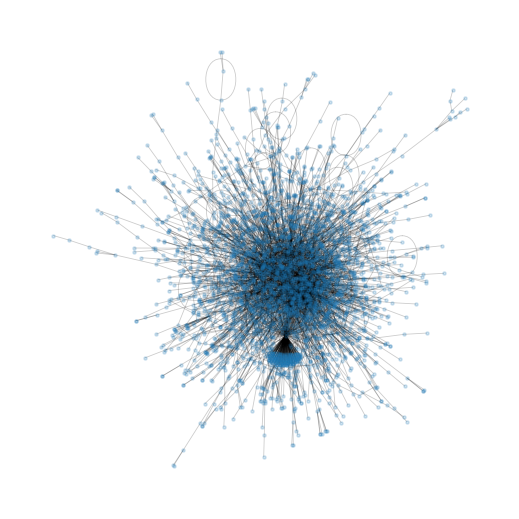

In [19]:
connected_edges = train_set[train_set['connected'] == 1]
training_graph = nx.from_pandas_edgelist(connected_edges, source='node1', target='node2', create_using=nx.Graph())
plt.figure(figsize=(5,5))

nx.draw(training_graph, node_size = 5, alpha = 0.2, width = 0.6)

plt.show()

In [40]:
# create test samples
test_samples = [tuple((element[0], element[1])) for element in test_set.values]
# create train and val samples
samples = list(zip(train_set['node1'], train_set['node2']))
labels = train_set['connected']
train_samples, val_samples, train_labels, val_labels = train_test_split(samples, labels, test_size=0.2, random_state=42)

# Afficher la taille des ensembles
print("Nombre d'échantillons d'entraînement :", len(train_samples))
print("Nombre d'échantillons de validation :", len(val_samples))

# Repartition des labels dans val et train
print("Nombre de labels positifs dans l'ensemble d'entraînement :", sum(train_labels))
print("Nombre de labels positifs dans l'ensemble de validation :", sum(val_labels))


Nombre d'échantillons d'entraînement : 8396
Nombre d'échantillons de validation : 2100
Nombre de labels positifs dans l'ensemble d'entraînement : 4207
Nombre de labels positifs dans l'ensemble de validation : 1041


In [ ]:
def generate_samples(graph, train_set_ratio):
    """
    Graph pre-processing step required to perform supervised link prediction
    Create training and test sets
    """
        
    # --- Step 0: The graph must be connected ---
    if nx.is_connected(graph) is not True:
        raise ValueError("The graph contains more than one connected component!")
       
    
    # --- Step 1: Generate positive edge samples for testing set ---
    residual_g = graph.copy()
    test_pos_samples = []
      
    # Shuffle the list of edges
    edges = list(residual_g.edges())
    np.random.shuffle(edges)
    
    # Define number of positive samples desired
    test_set_size = int((1.0 - train_set_ratio) * graph.number_of_edges())
    num_of_pos_test_samples = 0
    
    # Remove random edges from the graph, leaving it connected
    # Fill in the blanks
    while nx.is_connected(residual_g) and num_of_pos_test_samples < test_set_size:
        edge = edges.pop()
        residual_g.remove_edge(*edge)
        if nx.is_connected(residual_g) is False:
            residual_g.add_edge(*edge)
        else:
            test_pos_samples.append(edge)
            num_of_pos_test_samples += 1
    

    # Check if we have the desired number of positive samples for testing set 
    if num_of_pos_test_samples != test_set_size:
        raise ValueError("Enough positive edge samples could not be found!")

        
    # --- Step 2: Generate positive edge samples for training set ---
    # The remaining edges are simply considered for positive samples of the training set
    train_pos_samples = list(residual_g.edges())
        
        
    # --- Step 3: Generate the negative samples for testing and training sets ---
    # Fill in the blanks
    
    train_neg_samples = random.sample(list(nx.non_edges(residual_g)), len(train_pos_samples))

    # Générer des échantillons négatifs pour les tests
    test_neg_samples = random.sample(list(nx.non_edges(residual_g))[len(train_pos_samples):], len(test_pos_samples))
    
    # --- Step 4: Combine sample lists and create corresponding labels ---
    # For training set
    train_samples = train_pos_samples + train_neg_samples
    train_labels = [1 for _ in train_pos_samples] + [0 for _ in train_neg_samples]
    # For testing set
    test_samples = test_pos_samples + test_neg_samples
    test_labels = [1 for _ in test_pos_samples] + [0 for _ in test_neg_samples]
    
    return residual_g


In [ ]:
def feature_extractor(graph, samples):
    """
    Creates a feature vector for each edge of the graph contained in samples 
    """
    feature_edge_vector = [] 
    deg_centrality = nx.degree_centrality(graph)
    print('Calculate betweeness centrality')
    # Betweeness centrality measure
    # betweeness_centrality = nx.betweenness_centrality(graph)
    print('Calculate features for each edge in the graph')
    print('Calculate features for each edge in the graph')
    for edge in tqdm.tqdm(samples):
        source_node, target_node = edge[0], edge[1]
        # source_node_information = list(node_information.loc[node_information['node_id'] == int(source_node)].iloc[0, 1:])
        # target_node_information = list(node_information.loc[node_information['node_id'] == int(target_node)].iloc[0, 1:])
       
        # Degree Centrality 
        if source_node not in deg_centrality or target_node not in deg_centrality:
            source_degree_centrality = 0
            target_degree_centrality = 0
        else:
            source_degree_centrality = deg_centrality[source_node]
            target_degree_centrality = deg_centrality[target_node]
            
        # # Betweeness centrality 
        # if source_node not in betweeness_centrality or target_node not in betweeness_centrality:
        #     diff_bt = 0
        # else:
        #     diff_bt = betweeness_centrality[source_node] - betweeness_centrality[target_node]

        # Preferential Attachement 
        if source_node not in graph or target_node not in graph:
            pref_attach = 0
        else:
            pref_attach = list(nx.preferential_attachment(graph, [(source_node, target_node)]))[0][2]

        # AdamicAdar
        if source_node not in graph or target_node not in graph:
            aai = 0
        else:
            aai = sum(1 / np.log(graph.degree(z)) for z in nx.common_neighbors(graph, source_node, target_node))
            if np.isinf(aai):
                print('aai is inf')
                aai = 0
        # Compute the Jaccard coefficient
        if source_node not in graph or target_node not in graph:
            jacard_coeff = 0
        else:
            neighbords_source, neighbord_target = set(graph.neighbors(source_node)), set(graph.neighbors(target_node))
            inter = len(neighbords_source.intersection(neighbord_target))
            union = len(neighbords_source.union(neighbord_target))
            jacard_coeff = inter/union 
            if union == 0:
                print('union is 0')
                jacard_coeff = 0
                
        # Create edge feature vector with all metric computed above
        feature_edge_vector.append(np.array([source_degree_centrality, target_degree_centrality, pref_attach, aai, jacard_coeff]) ) 

         # Create edge feature vector with all metric computed above
        # feature_vector.append(np.concatenate([source_node_information, target_node_information,feature_edge_vector])) 
    return np.array(feature_edge_vector)

In [ ]:

# --- Construct the training and testing sets ---
residual_g, train_samples, train_labels, val_samples, val_labels = generate_samples(graph=training_graph, train_set_ratio=0.8)

# --- Create feature vector for all edges in training set and val set ---
train_features = feature_extractor(residual_g, train_samples, node_information)
val_features = feature_extractor(residual_g, val_samples, node_information)
test_features = feature_extractor(training_graph, test_samples, node_information)

Calculate betweeness centrality
Calculate features for each edge in the graph
Calculate features for each edge in the graph


  0%|          | 0/8398 [00:00<?, ?it/s]/var/folders/h1/60s3lm216j19z_94ccr7mdbh0000gn/T/ipykernel_83820/920959083.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  aai = sum(1 / np.log(graph.degree(z)) for z in nx.common_neighbors(graph, source_node, target_node))
100%|██████████| 8398/8398 [00:00<00:00, 61388.44it/s]


aai is inf
aai is inf
aai is inf
aai is inf
aai is inf
aai is inf
Calculate betweeness centrality
Calculate features for each edge in the graph
Calculate features for each edge in the graph


100%|██████████| 2098/2098 [00:00<00:00, 75342.69it/s]


aai is inf
aai is inf
aai is inf
aai is inf
aai is inf
aai is inf
Calculate betweeness centrality
Calculate features for each edge in the graph
Calculate features for each edge in the graph


100%|██████████| 3498/3498 [00:00<00:00, 113281.67it/s]

aai is inf
aai is inf
aai is inf
aai is inf


In [ ]:
len(train_samples)

8398

In [ ]:
train_features.shape 

(8398, 5)

# 2. Create Train, Val and Test Dataset

In [ ]:
from sklearn.preprocessing import StandardScaler
from torch_geometric.loader import NeighborLoader, LinkNeighborLoader, LinkLoader, NodeLoader

In [ ]:
x = torch.tensor(node_information.values, dtype=torch.float)

# Convert labels to PyTorch tensor
y_train = torch.tensor([[1 if label == 0 else 0, 1 if label == 1 else 0] for label in train_labels], dtype=torch.long)
y_val = torch.tensor([[1 if label == 0 else 0, 1 if label == 1 else 0] for label in val_labels], dtype=torch.long)

# Convert edge indices to PyTorch tensor
edge_index_train = torch.tensor(train_samples,dtype=torch.long).transpose(0, 1)
edge_index_val = torch.tensor(val_samples, dtype=torch.long).transpose(0,1)
edge_index_test = torch.tensor(test_samples, dtype=torch.long).transpose(0,1)

# create edge features 
edge_attr_train = torch.tensor(train_features, dtype=torch.float)
edge_attr_val = torch.tensor(val_features, dtype=torch.float)
edge_attr_test = torch.tensor(test_features, dtype=torch.float)


torch.Size([8398, 5])

In [ ]:

# Create Data objects for train and validation sets
data_train = Data(x=x, edge_index=edge_index_train ,y=y_train)
data_val = Data(x=x, edge_index=edge_index_val,y=y_val)

data_train
# # create dataloader for train et val
batch_size = 1
train_data_loader = NeighborLoader(data_train, num_neighbors=[-1], batch_size=batch_size, shuffle=True)
val_data_loader = NeighborLoader(data_val, num_neighbors=[-1], batch_size=batch_size, shuffle=True)


: 

: 

In [ ]:
data_val

Data(x=[3597, 933], edge_index=[2, 2098], y=[2098, 2])

In [ ]:

# train_loader = NeighborLoader(data_train, num_neighbors=[-1], batch_size=32, shuffle=True)
# val_loader = NeighborLoader(data_val, num_neighbors=[-1], batch_size=32, shuffle=True)

# 3. Model

In [ ]:
class GATModel(nn.Module):
  def __init__(self, input_size, hidden_size, hidden_size_bis, output_size_embed):
    super().__init__()
    # self.conv1 = GATv2Conv(input_size, hidden_size, heads=6)
    # self.conv2 = GATv2Conv(6 * hidden_size, hidden_size, heads=4)
    # self.conv3 = GATv2Conv(4 * hidden_size, hidden_size_bis, heads=4)
    # self.conv4 = GATv2Conv(4 * hidden_size_bis, output_size_embed, heads=6, concat=False)

    self.conv1 = SAGEConv(input_size, hidden_size, aggr="max")
    self.conv2 = SAGEConv(hidden_size, hidden_size_bis, aggr="mean")
    self.conv3 = SAGEConv(hidden_size_bis, hidden_size_bis//2, aggr="max")
    self.conv4 = SAGEConv(hidden_size_bis//2, hidden_size_bis//2, aggr="mean")
    self.conv5 = SAGEConv(hidden_size_bis//2, output_size_embed, aggr="max")

    self.lin1 = nn.Linear(2 * output_size_embed, output_size_embed)
    self.lin2 = nn.Linear(output_size_embed, output_size_embed)
    self.lin3 = nn.Linear(output_size_embed, output_size_embed//2)
    self.lin4 = nn.Linear(output_size_embed//2, 2)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.conv2(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.conv3(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.conv4(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.conv5(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)

    row, col = edge_index
    x = torch.cat([x[row], x[col]], dim=1)
    x = self.lin1(x)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.lin2(x)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.lin3(x)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.lin4(x)

    return x

In [ ]:
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y.float())
        predict = np.where(output.detach().cpu().numpy()[:, 1] >= 0, 1, 0)
        score = accuracy_score(batch.y.cpu().numpy()[:, 1], predict)
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

In [ ]:
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            output = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(output, train_batch_device.y.float())
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("Accuracy Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

In [ ]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

# Create the GAT model
model = GATModel(input_size=x.shape[1], hidden_size=500, hidden_size_bis=400, output_size_embed=300).to(device)

# Define the loss function and optimizer
loss_fcn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)

max_epochs=200


Device:  cpu


In [ ]:
# Train with mini-batches
epoch_list, model_scores = train(
    model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_data_loader,
    val_data_loader,
)

NameError: name 'train_data_loader' is not defined

In [ ]:
# Evaluation on val set batch

score_list_batch = []
predict_list_batch = []
y_list_batch = []

model.eval()
for i, batch in enumerate(val_data_loader):
    batch = batch.to(device)
    output = model(batch.x, batch.edge_index)
    predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
    score = accuracy_score(batch.y.cpu().numpy()[:, 1], predict[:, 1])

    score_list_batch.append(score)
    predict_list_batch.append(predict)
    y_list_batch.append(batch.y.cpu().numpy()[:, 1].mean())

In [ ]:
np.array((score_list_batch)).mean()

In [ ]:
# Train without mini-batches
data_train_device = data_train.to(device)
data_val_device = data_val.to(device)

for epoch in range(max_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data_train_device.x, data_train_device.edge_index)
    loss = loss_fcn(out, data_train_device.y.float())
    loss.backward()
    optimizer.step()

    print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss.item()))


    model.eval()
    output = model(data_val_device.x, data_val_device.edge_index)
    loss_test = loss_fcn(output, data_val_device.y.float())
    predict = np.where(output.detach().cpu().numpy()[:, 1] >= 0.5, 1, 0)
    score = accuracy_score(data_val_device.y.cpu().numpy()[:, 1], predict)
    print("Accuracy core: {:.4f}".format(score))

In [ ]:
model.eval()
output = model(x.to(device), edge_index_test.to(device))
pred_test = np.where(output.detach().cpu().numpy() >= 0, 1, 0)[:, 1]

In [ ]:
pred_test

In [ ]:
preds = zip(np.array(range(len(test_set))), pred_test)

In [ ]:
import os
import csv

os.makedirs("models", exist_ok=True)
i = len(os.listdir("models")) +1
model_path = f"models/model_{i}.csv"

with open(model_path,"w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in preds:
         csv_out.writerow(row)
    pred.close()
